In [3]:
import re
import scanpy
from fuzzywuzzy import process
import pandas as pd
import numpy as np
#https://www.biostars.org/p/317524/
import sys
import os
import gzip
import tqdm
import seaborn

def processfq(lines=None):
    ks = ['name', 'sequence', 'optional', 'quality']
    return {k: v for k, v in zip(ks, lines)}

In [2]:
eighttwelve=pd.read_csv('/wynton/group/ye/mtschmitz/macaquedevbrain/MULTISEQmacaque/8-12IndexConversion.txt',sep='\t')
etdict=dict(zip(eighttwelve['8-Index'],eighttwelve['12-Index']))

In [44]:
fq1='/wynton/group/ye/mtschmitz/macaquedevbrain/MULTISEQmacaque/pollena-MULTIseq_E80/MULTIseq_E80_S97_L002_R1_001.fastq'
#fq2='/wynton/group/ye/mtschmitz/macaquedevbrain/MULTISEQmacaque/pollena-MULTIseq_E65-1/MULTIseq_E65-1_S99_L002_R2_001.fastq.gz'
fq2=re.sub('_R1_','_R2_',fq1)
indexfile='/wynton/group/ye/mtschmitz/macaquedevbrain/MULTISEQmacaque/MultiseqIndices.txt'
cellfile='/wynton/scratch/mtschmitz/fastqpool/E80-2019_Multi-seq_kOut/cellbendedcells.txt'
outfile='/wynton/scratch/mtschmitz/fastqpool/E80-2019_Multi-seq_kOut/'
pf='0'
plate_flipped=True if pf == '1' else False
print(plate_flipped)
Indices=pd.read_csv(indexfile,sep='\t')
Indices.index=Indices.index+1
key=pd.read_csv('/wynton/group/ye/mtschmitz/macaquedevbrain/MULTISEQmacaque/pollena-MULTIseq_E80/MultiseqKey.txt',sep='\t')
key=key.replace(np.nan, '', regex=True)
key.index=key['Multiseq Index']
if plate_flipped:
    key['Multiseq Index']=[etdict[x] for x in key['Multiseq Index']]
#Somewhat adhoc for my multiseq format key
keydict=dict(zip(key['Multiseq Index'],key['Timepoint']+'-2019'+key['Individual']+'_'+key['Sample']))

False


In [4]:
n = 4
readpairs=[]
i=0
with open(fq1, 'r') as fh:
    with open(fq2, 'r') as rh:
        flines = []
        rlines = []
        linef = fh.readline()
        liner = rh.readline()
        while linef and liner:
            flines.append(linef.rstrip())
            rlines.append(liner.rstrip())
            if (len(flines) == n) and (len(rlines) == n):
                recordf = processfq(flines)
                recordr = processfq(rlines)
                readpairs.append([recordf['sequence'][0:16],recordr['sequence'][0:8]])
                flines = []
                rlines = []
            i+=1
            if i%100000==0:
                print(i)
            linef = fh.readline()
            liner = rh.readline()

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000


In [5]:
df=pd.DataFrame(readpairs)

In [8]:
cells=[]
with open(cellfile) as f:
    for l in f.readlines():
        if len(l)>2:
            cells.append(re.sub('\n','',l))

cellset=list(set(cells))
Indices=Indices.loc[Indices.index.isin(key.index),:]
inds=list(Indices['Barcode Sequence'])
inddictrev=dict(zip(Indices.index,Indices['Barcode Sequence']))
inddict=dict(zip(inddictrev.values(),inddictrev.keys()))

celldictrev=dict(enumerate(cellset))
celldict=dict(zip(celldictrev.values(),celldictrev.keys()))

mat=np.zeros((len(cellset),len(inds)),dtype=np.int32)


In [9]:
bcfixed=[process.extractOne(x,inddictrev) for x in tqdm.tqdm(df[1])]

100%|██████████| 1389807/1389807 [09:06<00:00, 2542.29it/s]


In [10]:
df=df.loc[[x is not None for x in bcfixed],:]
df[1]=[x[2] for x in bcfixed if x is not None]

In [12]:
import re

def ngrams(string, n=8):
    string = re.sub(r'[,-./]|\sBD',r'', string)
    ngrams = zip(*[string[i:] for i in range(n)])
    return [''.join(ngram) for ngram in ngrams]

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=1, analyzer=ngrams)
tf_idf_matrix = vectorizer.fit_transform(cellset+list(df[0]))

In [13]:
tf_idf_matrix_ref=tf_idf_matrix[:len(cellset),:]

In [14]:
tf_idf_matrix_query=tf_idf_matrix[len(cellset):,:]

In [15]:
import numpy as np
from scipy.sparse import csr_matrix
import sparse_dot_topn
import sparse_dot_topn.sparse_dot_topn as ct

def awesome_cossim_top(A, B, ntop, lower_bound=0):
    # force A and B as a CSR matrix.
    # If they have already been CSR, there is no overhead
    A = A.tocsr()
    B = B.tocsr()
    M, _ = A.shape
    _, N = B.shape
 
    idx_dtype = np.int32
 
    nnz_max = M*ntop
 
    indptr = np.zeros(M+1, dtype=idx_dtype)
    indices = np.zeros(nnz_max, dtype=idx_dtype)
    data = np.zeros(nnz_max, dtype=A.dtype)

    ct.sparse_dot_topn(
        M, N, np.asarray(A.indptr, dtype=idx_dtype),
        np.asarray(A.indices, dtype=idx_dtype),
        A.data,
        np.asarray(B.indptr, dtype=idx_dtype),
        np.asarray(B.indices, dtype=idx_dtype),
        B.data,
        ntop,
        lower_bound,
        indptr, indices, data)

    return csr_matrix((data,indices,indptr),shape=(M,N))

def get_matches_df(sparse_matrix, name_vectorx,name_vectory, top=100):
    non_zeros = sparse_matrix.nonzero()
    sparserows = non_zeros[0]
    sparsecols = non_zeros[1]

    sparserows=sparse_matrix.argmax(1).A1
    sparsecols=list(range(len(name_vectory)))
    left_side = name_vectorx
    right_side = np.array(name_vectory)[sparserows]
    similarity=[]
    for x,y in zip(list(range(len(name_vectorx))),sparserows):
        similarity.append(sparse_matrix[x,y])
    
    return pd.DataFrame({'original': left_side,
                          'matched': right_side,
                           'similarity': similarity})

matches = awesome_cossim_top(tf_idf_matrix_query,tf_idf_matrix_ref.transpose(), 1)

In [16]:
matchdf=get_matches_df(matches,list(df[0]),cellset,False)

In [17]:
df[0]=matchdf['matched']

In [18]:
df=df.loc[list(matchdf['similarity']>.7),:]

In [19]:
df

,0,1
1,CGCATGGTCTTCTAAC,34
2,ATTCGTTAGAGGTTAT,27
3,CTGTGAAGTTGGAGAC,26
4,CCACAAATCAGAGTTC,26
5,CGCAGGTTCTCATGGA,27
...,...,...
1389800,AATGGCTTCCAAGCCG,2
1389801,GTAGAGGCACTCACTC,27
1389802,CTAACCCAGTCTTCCC,2
1389803,GGGAGATTCAGGGTAG,26


In [8]:
mat=df.groupby([0,1]).size().unstack(fill_value=0)
mat.columns=[keydict[x] for x in mat.columns]
mat.astype('int')
mat.to_csv(os.path.join(outfile,'MULTIseq_counts.txt'),sep='\t',header=True,index=True)

KeyError: 0

In [15]:
outfile='/wynton/scratch/mtschmitz/fastqpool/E80-2019_Multi-seq_kOut/MULTIseq_counts.txt'
mat=pd.read_csv(outfile,sep='\t',index_col=0).astype('int')

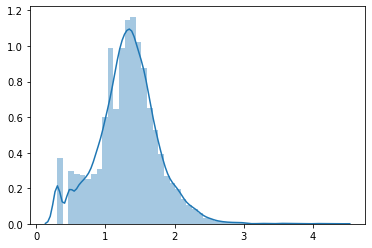

In [16]:
seaborn.distplot(np.log10(mat.sum(1)+1))

In [17]:
amat=np.array(mat)
amat.sort(axis=1)

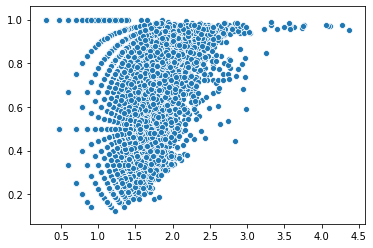

In [18]:
seaborn.scatterplot(np.log10(mat.sum(1)+1),((np.matrix(mat)/np.matrix(mat.sum(1)).T).max(1)).A1)

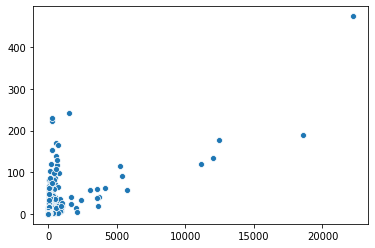

In [19]:
seaborn.scatterplot((amat[:,-1]),(amat[:,-2]))

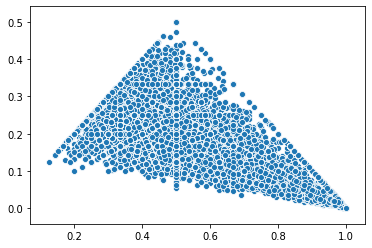

In [20]:
seaborn.scatterplot((amat[:,-1]/amat.sum(1)),(amat[:,-2]/amat.sum(1)))

In [107]:
import umap
import matplotlib.pyplot as plt
reducer = umap.UMAP(n_neighbors=15,metric='jaccard')
embedding = reducer.fit_transform(amat)

/wynton/home/ye/mschmitz1/utils/miniconda3/envs/scanpy/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../utils/miniconda3/envs/scanpy/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  state.func_ir.loc))
/wynton/home/ye/mschmitz1/utils/miniconda3/envs/scanpy/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 13 separate connected components using meta-embedding (experimental)
  n_components
/wynton/home/ye/mschmitz1/utils/miniconda3/envs/scanpy/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1735: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg

In [108]:
from sklearn import mixture
dpgmm = mixture.GaussianMixture(n_components=amat.shape[1]+1,
                                        covariance_type='full').fit(amat)

In [109]:
clusters=dpgmm.predict(amat)

Text(0.5, 1.0, 'UMAP')

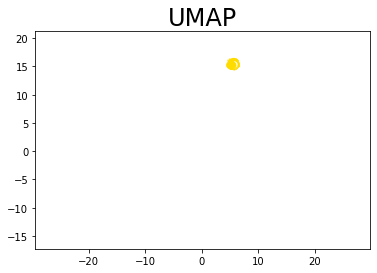

In [113]:
import matplotlib
import matplotlib.cm as cm
v=amat.sum(1)
norm = matplotlib.colors.Normalize(vmin=0, vmax=max(v))
cmap = cm.hot
m = cm.ScalarMappable(norm=norm, cmap=cmap)
plt.scatter(embedding[:, 0], embedding[:, 1], c=[m.cmap(np.log(x+1)) for x in v])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP', fontsize=24)

Text(0.5, 1.0, 'UMAP')

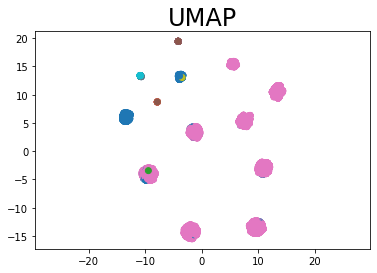

In [112]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=[seaborn.color_palette(n_colors=20)[x] for x in clusters])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP', fontsize=24)

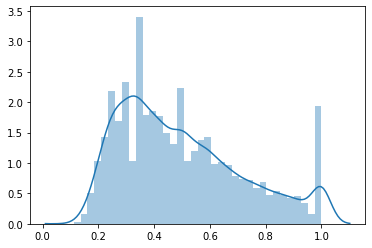

In [44]:
seaborn.distplot((amat[:,-1]/amat.sum(1))/(amat[:,-2]/amat.sum(1)+1))
